# Medication-Labtest Pairs Retieval and T-Test P-values

## Import Libraries

In [1]:
import pandas as pd
import datetime
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, metrics

## Load Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PARENT='/content/drive/MyDrive/TAU'
DATA = PARENT+'/Datasets/mimiciii/1.4'

In [5]:
RESULT = PARENT+'/Results'

In [6]:
for i in os.walk(os.path.join(DATA)):
    print(i)

('/content/drive/MyDrive/TAU/Datasets/mimiciii/1.4', [], ['CALLOUT.csv.gz', 'ADMISSIONS.csv.gz', 'CAREGIVERS.csv.gz', 'D_ITEMS.csv.gz', 'D_ICD_PROCEDURES.csv.gz', 'D_ICD_DIAGNOSES.csv.gz', 'ICUSTAYS.csv.gz', 'CHARTEVENTS.csv.gz', 'DRGCODES.csv.gz', 'CPTEVENTS.csv.gz', 'DIAGNOSES_ICD.csv.gz', 'D_CPT.csv.gz', 'D_LABITEMS.csv.gz', 'DATETIMEEVENTS.csv.gz', 'INPUTEVENTS_CV.csv.gz', 'INPUTEVENTS_MV.csv.gz', 'LABEVENTS.csv.gz', 'MICROBIOLOGYEVENTS.csv.gz', 'OUTPUTEVENTS.csv.gz', 'PATIENTS.csv.gz', 'README.md', 'PROCEDURES_ICD.csv.gz', 'PRESCRIPTIONS.csv.gz', 'TRANSFERS.csv.gz', 'PROCEDUREEVENTS_MV.csv.gz', 'SERVICES.csv.gz', 'LICENSE.txt', 'NOTEEVENTS.csv.gz', 'SHA256SUMS.txt', 'index.html'])


## Load Data

### Labevents

In [7]:
labevents = pd.read_csv(os.path.join(DATA, 'LABEVENTS.csv.gz')).dropna()
d_labitems = pd.read_csv(os.path.join(DATA, 'D_LABITEMS.csv.gz')).dropna()

In [8]:
labevents.shape, d_labitems.shape

((7881769, 9), (585, 6))

In [9]:
labevents

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
162,443,3,145834.0,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal
163,444,3,145834.0,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal
166,447,3,145834.0,50912,2101-10-20 16:40:00,3.2,3.2,mg/dL,abnormal
169,450,3,145834.0,50970,2101-10-20 16:40:00,4.8,4.8,mg/dL,abnormal
170,451,3,145834.0,50971,2101-10-20 16:40:00,5.4,5.4,mEq/L,abnormal
...,...,...,...,...,...,...,...,...,...
27854045,27428430,96443,103219.0,50862,2109-12-30 01:40:00,2.2,2.2,g/dL,abnormal
27854046,27428431,96443,103219.0,50863,2109-12-30 01:40:00,172,172.0,IU/L,abnormal
27854049,27428434,96443,103219.0,50878,2109-12-30 01:40:00,467,467.0,IU/L,abnormal
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.1,mg/dL,abnormal


In [10]:
labValues = pd.merge(labevents, d_labitems, on='ITEMID', how='inner')

In [11]:
labValues.shape

(7876570, 14)

In [12]:
# subject_id,l.hadm_id, d.label, l.valuenum, l.valueuom, l.charttime
labValues = labValues[['SUBJECT_ID', 'HADM_ID', 'LABEL', 'VALUENUM', 'VALUEUOM', 'CHARTTIME']]

In [13]:
labValues['CHARTTIME'] = pd.to_datetime(labValues['CHARTTIME'],  format='%Y/%m/%d %H:%M:%S')

In [14]:
labValues

,SUBJECT_ID,HADM_ID,LABEL,VALUENUM,VALUEUOM,CHARTTIME
0,3,145834.0,"Calcium, Total",8.2,mg/dL,2101-10-20 16:40:00
1,3,145834.0,"Calcium, Total",7.6,mg/dL,2101-10-22 04:00:00
2,3,145834.0,"Calcium, Total",7.1,mg/dL,2101-10-22 21:15:00
3,3,145834.0,"Calcium, Total",7.5,mg/dL,2101-10-23 03:45:00
4,3,145834.0,"Calcium, Total",7.4,mg/dL,2101-10-20 19:59:00
...,...,...,...,...,...,...
7876565,53160,138843.0,Plasma,1.0,%,2194-06-27 13:52:00
7876566,96240,168044.0,Plasma,7.0,%,2105-05-16 16:45:00
7876567,40200,108146.0,Sex Hormone Binding Globulin,12.0,nmol/L,2165-01-10 16:00:00
7876568,58010,185994.0,Sex Hormone Binding Globulin,11.0,nmol/L,2109-02-19 00:16:00


In [15]:
del labevents, d_labitems

### Admissions

In [16]:
admissions = pd.read_csv(os.path.join(DATA, 'ADMISSIONS.csv.gz'))

In [17]:
# subject_id,hadm_id
admissions = admissions[['SUBJECT_ID', 'HADM_ID']]
admissions

,SUBJECT_ID,HADM_ID
0,22,165315
1,23,152223
2,23,124321
3,24,161859
4,25,129635
...,...,...
58971,98800,191113
58972,98802,101071
58973,98805,122631
58974,98813,170407


### Input Events MV

In [18]:

inputevents_mv = pd.read_csv(os.path.join(DATA, 'INPUTEVENTS_MV.csv.gz'), nrows=500000)

In [19]:
inputevents_mv.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME', 'ENDTIME',
       'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'RATE', 'RATEUOM', 'STORETIME', 'CGID',
       'ORDERID', 'LINKORDERID', 'ORDERCATEGORYNAME',
       'SECONDARYORDERCATEGORYNAME', 'ORDERCOMPONENTTYPEDESCRIPTION',
       'ORDERCATEGORYDESCRIPTION', 'PATIENTWEIGHT', 'TOTALAMOUNT',
       'TOTALAMOUNTUOM', 'ISOPENBAG', 'CONTINUEINNEXTDEPT', 'CANCELREASON',
       'STATUSDESCRIPTION', 'COMMENTS_EDITEDBY', 'COMMENTS_CANCELEDBY',
       'COMMENTS_DATE', 'ORIGINALAMOUNT', 'ORIGINALRATE'],
      dtype='object')

In [20]:
inputevents_mv['ORDERCATEGORYNAME'].value_counts()

01-Drips                    196312
02-Fluids (Crystalloids)     76453
08-Antibiotics (IV)          59048
14-Oral/Gastric Intake       51766
05-Med Bolus                 33985
13-Enteral Nutrition         18647
06-Insulin (Non IV)          15424
11-Prophylaxis (Non IV)      13991
10-Prophylaxis (IV)          10121
03-IV Fluid Bolus             9305
07-Blood Products             5369
12-Parenteral Nutrition       3146
16-Pre Admission              2787
09-Antibiotics (Non IV)       1861
04-Fluids (Colloids)          1768
15-Supplements                  17
Name: ORDERCATEGORYNAME, dtype: int64

### Item

In [21]:
d_item = pd.read_csv(os.path.join(DATA, 'D_ITEMS.csv.gz'))

In [22]:
# d_item[d_item['CATEGORY']=='Antibiotics']

### Item <> Input events MV

In [23]:
ditem_inputevents_mv = pd.merge(inputevents_mv, d_item, on='ITEMID', how='inner')

In [24]:
ditem_inputevents_mv.columns

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME',
       'ENDTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'RATE', 'RATEUOM',
       'STORETIME', 'CGID', 'ORDERID', 'LINKORDERID', 'ORDERCATEGORYNAME',
       'SECONDARYORDERCATEGORYNAME', 'ORDERCOMPONENTTYPEDESCRIPTION',
       'ORDERCATEGORYDESCRIPTION', 'PATIENTWEIGHT', 'TOTALAMOUNT',
       'TOTALAMOUNTUOM', 'ISOPENBAG', 'CONTINUEINNEXTDEPT', 'CANCELREASON',
       'STATUSDESCRIPTION', 'COMMENTS_EDITEDBY', 'COMMENTS_CANCELEDBY',
       'COMMENTS_DATE', 'ORIGINALAMOUNT', 'ORIGINALRATE', 'ROW_ID_y', 'LABEL',
       'ABBREVIATION', 'DBSOURCE', 'LINKSTO', 'CATEGORY', 'UNITNAME',
       'PARAM_TYPE', 'CONCEPTID'],
      dtype='object')

In [25]:
inputevents_mv_1 = ditem_inputevents_mv[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME', 'ENDTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'UNITNAME', 'ORDERCATEGORYNAME', 'LABEL', 'CATEGORY', 'PARAM_TYPE']]
inputevents_mv_1

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,UNITNAME,ORDERCATEGORYNAME,LABEL,CATEGORY,PARAM_TYPE
0,27063,139787,223259.0,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,6.774532,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
1,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 06:30:00,225166,2.813300,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
2,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 07:03:00,225166,4.433333,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
3,27063,139787,223259.0,2133-02-05 09:43:00,2133-02-05 12:30:00,225166,8.360021,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
4,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 05:35:00,225166,0.050060,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,65382,163918,288487.0,2132-12-09 02:35:00,2132-12-09 02:36:00,227692,0.004046,mg,mg,01-Drips,Isuprel,Medications,Solution
499996,60970,163433,274168.0,2132-02-08 05:37:00,2132-02-08 07:15:00,225148,249.999999,mg,mg,01-Drips,Bivalirudin (Angiomax),Medications,Solution
499997,45426,166752,236992.0,2144-01-06 17:33:00,2144-01-07 00:16:00,226022,134.333336,ml,mL,13-Enteral Nutrition,Impact (3/4),Nutrition - Enteral,Solution
499998,54586,122570,222417.0,2168-03-09 11:00:00,2168-03-09 12:00:00,225173,7500.000000,ml,mL,07-Blood Products,Cell Saver,Blood Products/Colloids,Solution


In [26]:
top200_meds = inputevents_mv_1['LABEL'].value_counts()[:200]

In [27]:
inputevents_mv_1['CATEGORY'].value_counts()

Fluids/Intake              242772
Medications                196463
Antibiotics                 31382
Nutrition - Enteral         18661
Blood Products/Colloids      7929
Nutrition - Parenteral       2790
Nutrition - Supplements         3
Name: CATEGORY, dtype: int64

In [28]:
inputevents_mv_1['STARTTIME'] = pd.to_datetime(inputevents_mv_1['STARTTIME'],  format='%Y/%m/%d %H:%M:%S')
inputevents_mv_1['ENDTIME'] = pd.to_datetime(inputevents_mv_1['ENDTIME'],  format='%Y/%m/%d %H:%M:%S')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Data Preprocessing

In [29]:
def remove_multiple_admissions(df):
    """
    Removes hospital admissions that occur more than once for the same patient
  
    Parameters:
    df (DataFrame): Takes in dataframe with multiple hospital admissions
  
    Returns:
    Dataframe: Returns dataframe with multiple hospital admissions removed
    """
    first_admissions = admissions
    first_admissions = first_admissions.drop_duplicates(subset=['SUBJECT_ID'], keep='first')
    df = df[df['HADM_ID'].isin(first_admissions['HADM_ID'])]
    return df

In [30]:
lab_measurements = labValues

In [31]:
top200_meds = pd.DataFrame(top200_meds, columns=['LABEL']).reset_index()
top200_meds.rename(columns = {'index':'MED', 'LABEL':'COUNT'}, inplace = True)
top200_meds

,MED,COUNT
0,NaCl 0.9%,76138
1,Dextrose 5%,60536
2,Solution,27506
3,Propofol,20005
4,PO Intake,19287
...,...,...
195,Nutren 2.0 (1/2),7
196,Nutren 2.0 (3/4),7
197,Valgancyclovir,7
198,Magnesium Sulfate (OB-GYN),5


In [32]:
patient_presc = inputevents_mv_1

In [33]:
patient_presc = remove_multiple_admissions(patient_presc)
patient_presc = inputevents_mv_1[inputevents_mv_1['LABEL'].isin(top200_meds['MED'])]

In [34]:
patient_presc

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,UNITNAME,ORDERCATEGORYNAME,LABEL,CATEGORY,PARAM_TYPE
0,27063,139787,223259.0,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,6.774532,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
1,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 06:30:00,225166,2.813300,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
2,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 07:03:00,225166,4.433333,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
3,27063,139787,223259.0,2133-02-05 09:43:00,2133-02-05 12:30:00,225166,8.360021,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
4,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 05:35:00,225166,0.050060,mEq,mEq,02-Fluids (Crystalloids),Potassium Chloride,Medications,Solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499991,65382,163918,288487.0,2132-12-09 04:42:00,2132-12-09 08:49:00,227692,0.999294,mg,mg,01-Drips,Isuprel,Medications,Solution
499992,65382,163918,288487.0,2132-12-09 01:36:00,2132-12-09 01:49:00,227692,0.117747,mg,mg,01-Drips,Isuprel,Medications,Solution
499993,65382,163918,288487.0,2132-12-09 02:10:00,2132-12-09 02:20:00,227692,0.060357,mg,mg,01-Drips,Isuprel,Medications,Solution
499994,65382,163918,288487.0,2132-12-09 04:45:00,2132-12-09 14:50:00,227692,2.420000,mg,mg,01-Drips,Isuprel,Medications,Solution


In [35]:
lab_measurements = lab_measurements[lab_measurements.duplicated(subset=['SUBJECT_ID','LABEL'],keep=False)]
lab_measurements = lab_measurements[lab_measurements['HADM_ID'].isin(patient_presc['HADM_ID'])]

## Generating Lab Test<>Meds Pairings

In [36]:
def labpairing(medname, prescdf, labdf, labname):
    """Pairs the drug input with each lab test

    Parameters:
    drugname (String): Drug Name
    prescdf (DataFrame): Dataframe containing the prescription data
    labdf (DataFrame): Dataframe containing the lab measurement data
    labname (DataFrame): Lab Test Name
    Returns:
    DataFrame: Contains all the rows of values and times for that particular drug lab apir
  
    """
    # Select patients who have taken the drug
    prescdf = prescdf[prescdf['LABEL']==medname]
    prescdf = prescdf.drop_duplicates(subset=['SUBJECT_ID'], keep='first')

    # Select lab measurements of patients who have taken the drug
    labdf = labdf[labdf['HADM_ID'].isin(prescdf['HADM_ID'])]

    # Selects the lab measurement entered
    drug_lab_specific = labdf[labdf['LABEL']==labname]
    mergeddf = pd.merge(drug_lab_specific, prescdf, on=['HADM_ID','SUBJECT_ID'])

    # Get time from prescription and choose before and after lab measurements (within 24hrs=1day)
    mergeddf['timeFromPrescription'] = mergeddf['CHARTTIME'] - mergeddf['STARTTIME']
    posmergeddf = mergeddf.loc[mergeddf.timeFromPrescription > datetime.timedelta(days=0)]
    negmergeddf = mergeddf.loc[mergeddf.timeFromPrescription < datetime.timedelta(days=0)]
    
    # Only keep values for which we have both before and after
    posmergeddf = posmergeddf[posmergeddf['HADM_ID'].isin(negmergeddf['HADM_ID'])]
    negmergeddf = negmergeddf[negmergeddf['HADM_ID'].isin(posmergeddf['HADM_ID'])]

    # Choose admissions which have more than one lab test reading
    before = posmergeddf
    bool_before = before.groupby('SUBJECT_ID').count()>1
    index_before = bool_before[bool_before['HADM_ID']==True].index
    before = posmergeddf[posmergeddf['SUBJECT_ID'].isin(index_before)]
    posmergeddf = posmergeddf.loc[posmergeddf.groupby('SUBJECT_ID').timeFromPrescription.idxmin()]

    after = negmergeddf
    bool_after = after.groupby('SUBJECT_ID').count()>1
    index_after = bool_after[bool_after['HADM_ID']==True].index
    after = after[after['SUBJECT_ID'].isin(index_after)]
    negmergeddf = negmergeddf.loc[negmergeddf.groupby('SUBJECT_ID').timeFromPrescription.idxmax()]

    before = before[before['HADM_ID'].isin(after['HADM_ID'])]
    after = after[after['HADM_ID'].isin(before['HADM_ID'])]

    finaldf = negmergeddf.merge(posmergeddf,on=['HADM_ID','SUBJECT_ID'])
    
    return finaldf, before, after

In [37]:
finalDF, before, after = labpairing('NaCl 0.9%', patient_presc, lab_measurements, 'Calcium, Total')

## Regression Analysis

In [38]:
subjects = before['SUBJECT_ID'].unique()

In [39]:
def get_min(col):
    return col.apply(lambda td : td.total_seconds()//60)

In [40]:
# Regression Analysis
def gen_estimate_coef(subjects, before, verbose=False):
    reg_anal_res = []
    lab_vals = []
    time = []

    for i in subjects:
        
        res_vals = dict()
        res_vals['subjectID'] = i
        
        rows = before[before['SUBJECT_ID']==i]
        rows = rows.sort_values(by='timeFromPrescription')

        x = rows['VALUENUM']
        y = get_min(rows['timeFromPrescription'])

        reg = linear_model.LinearRegression()
        reg.fit(np.array(y).reshape(-1,1), np.array(x).reshape(-1,1))

        res_vals['coef'] = reg.coef_[0][0]
        res_vals['estimated'] = reg.predict([[0]])[0][0]
        
        if verbose:
            print('Subject ID: ', i, '  Coefficients: ', reg.coef_)

        reg_anal_res.append(res_vals)

        lab_vals.append(x)
        time.append(y) 

    return reg_anal_res, lab_vals, time

In [41]:
before_reg_anal_res, before_lab_vals, before_time = gen_estimate_coef(subjects, before)

In [42]:
before_reg_anal_res[0]

{'coef': 8.7239707503295e-05, 'estimated': 7.776071200973191, 'subjectID': 222}

In [43]:
pd.DataFrame(before_reg_anal_res)

,subjectID,coef,estimated
0,222,0.000087,7.776071
1,402,-0.000125,8.369568
2,605,0.000045,7.312504
3,1106,-0.000061,9.914487
4,1180,0.000062,7.419881
...,...,...,...
569,99985,0.000038,7.621296
570,97330,-0.000001,7.853729
571,96546,0.000203,7.384303
572,98969,-0.000134,8.210220


In [44]:
after_reg_anal_res, after_lab_vals, after_time = gen_estimate_coef(subjects, after)

In [45]:
after_lab_vals[1].mean()

6.7

In [46]:
after_reg_anal_res[0]

{'coef': -0.0004663557628247835,
 'estimated': 5.962558294470353,
 'subjectID': 222}

In [47]:
pd.DataFrame(after_reg_anal_res)

,subjectID,coef,estimated
0,222,-0.000466,5.962558
1,402,0.000833,7.320000
2,605,0.000061,7.267702
3,1106,-0.000187,7.476476
4,1180,-0.000414,7.337507
...,...,...,...
569,99985,-0.000126,7.137703
570,97330,-0.000214,7.758877
571,96546,0.001170,7.364614
572,98969,0.000232,8.161637


In [48]:
print(before_time[1])
print(after_time[1])

63     635.0
64    2051.0
60    6183.0
Name: timeFromPrescription, dtype: float64
61   -1104.0
62    -384.0
Name: timeFromPrescription, dtype: float64


## Time VS Labtest Value Plots

In [49]:
def gen_plot_data(subjects, before_time, after_time, before_lab_vals, after_lab_vals):
    res = []
    for i, subject in enumerate(subjects):

        # Handling time
        x1 = list(before_time[i])
        before = list(map(lambda t: -1*t, x1))
        x2 = list(after_time[i])
        after = list(map(lambda t: -1*t, x2))
        before.reverse()
        after.reverse()
        before.extend(after)
        x = before

        # Handling labtest values
        y1 = list(before_lab_vals[i])
        y1.reverse()
        y2 = list(after_lab_vals[i])
        y2.reverse()
        y1.extend(y2)
        y = y1

        res.append([subject, x, y])
    
    return res

In [ ]:
res_data = gen_plot_data(subjects, before_time, after_time, before_lab_vals, after_lab_vals)

In [50]:
def plot_graph(res, limits=(0,1)):
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(limits[0], limits[1]):
        ax.plot(res[i][1], res[i][2], label = "Subject "+str(res[i][0]), linestyle="-")
        ax.legend()
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    plt.xlabel('Time After Medication')
    plt.title('Time VS Lab Test Values')

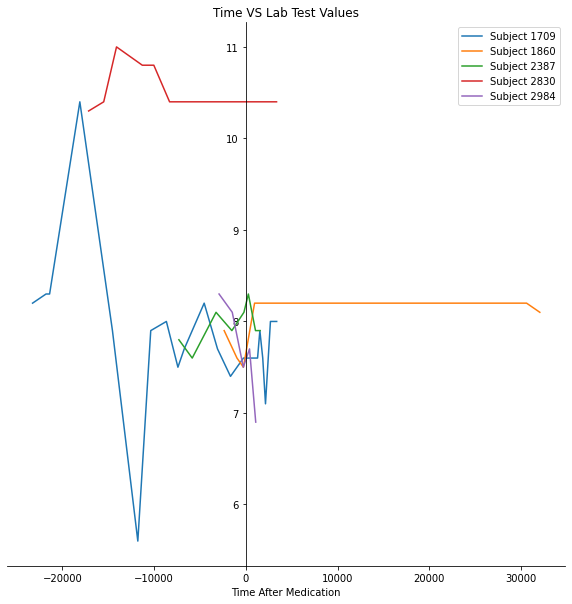

In [ ]:
plot_graph(res_data, (5,10))

## Final Analysis Functions - T test

In [66]:
def analysis_func(lab_measurements, top200_meds, n_medlab_pairs = 25, n_meds=None):
    res = pd.DataFrame(columns=['Medication','Lab Test','Number of patients','Estimated (mean)','Estimated (std)', 'Feature After(mean)','Feature After(std)','Time After(mean)','Time After(std)','Mannwhitney-pvalue','Ttest-pvalue'])
    uniqueLabTests = lab_measurements.LABEL.unique()
    final_res = []

    for i, med in enumerate(top200_meds['MED']): 
        if n_meds is not None and i>=n_meds:
            break
        print(i, ' MED: ', med)
        for j in tqdm(range(uniqueLabTests.shape[0])):
            labTest = uniqueLabTests[j]
            drug_lab, before, after = labpairing(med, patient_presc, lab_measurements, labTest)
            subjects = before['SUBJECT_ID'].unique()
            if(len(before) > n_medlab_pairs):
                before_reg_anal_res, before_lab_vals, before_time = gen_estimate_coef(subjects, before)
                after_reg_anal_res, after_lab_vals, after_time = gen_estimate_coef(subjects, after)
                estimated = np.array(pd.DataFrame(after_reg_anal_res)['estimated'])
                after_values = np.array([k.mean() for k in after_lab_vals])
                ttest_res = stats.ttest_ind(estimated, after_values)[1]
                final_res.append([med, labTest, ttest_res, after_values, len(before)])
    return final_res

In [63]:
final_res = analysis_func(lab_measurements, top200_meds, n_medlab_pairs = 25, n_meds=None)

0  MED:  NaCl 0.9%


100%|██████████| 161/161 [03:35<00:00,  1.34s/it]


1  MED:  Dextrose 5%


100%|██████████| 161/161 [02:40<00:00,  1.00it/s]


2  MED:  Solution


100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


3  MED:  Propofol


100%|██████████| 161/161 [01:29<00:00,  1.80it/s]


4  MED:  PO Intake


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


5  MED:  Insulin - Regular


100%|██████████| 161/161 [01:53<00:00,  1.42it/s]


6  MED:  Gastric Meds


100%|██████████| 161/161 [01:38<00:00,  1.63it/s]


7  MED:  Fentanyl


100%|██████████| 161/161 [01:26<00:00,  1.85it/s]


8  MED:  Norepinephrine


100%|██████████| 161/161 [00:58<00:00,  2.76it/s]


9  MED:  Phenylephrine


100%|██████████| 161/161 [01:01<00:00,  2.64it/s]


10  MED:  Potassium Chloride


100%|██████████| 161/161 [01:55<00:00,  1.39it/s]


11  MED:  Heparin Sodium (Prophylaxis)


100%|██████████| 161/161 [01:47<00:00,  1.50it/s]


12  MED:  GT Flush


100%|██████████| 161/161 [01:20<00:00,  2.00it/s]


13  MED:  Midazolam (Versed)


100%|██████████| 161/161 [01:16<00:00,  2.11it/s]


14  MED:  Vancomycin


100%|██████████| 161/161 [01:52<00:00,  1.43it/s]


15  MED:  LR


100%|██████████| 161/161 [01:22<00:00,  1.95it/s]


16  MED:  Furosemide (Lasix)


100%|██████████| 161/161 [01:30<00:00,  1.78it/s]


17  MED:  Replete with Fiber (Full)


100%|██████████| 161/161 [00:42<00:00,  3.81it/s]


18  MED:  Sterile Water


100%|██████████| 161/161 [01:03<00:00,  2.55it/s]


19  MED:  Morphine Sulfate


100%|██████████| 161/161 [01:03<00:00,  2.55it/s]


20  MED:  Piggyback


100%|██████████| 161/161 [01:31<00:00,  1.76it/s]


21  MED:  Piperacillin/Tazobactam (Zosyn)


100%|██████████| 161/161 [01:04<00:00,  2.51it/s]


22  MED:  KCL (Bolus)


100%|██████████| 161/161 [01:14<00:00,  2.15it/s]


23  MED:  Metoprolol


100%|██████████| 161/161 [01:05<00:00,  2.47it/s]


24  MED:  Insulin - Humalog


100%|██████████| 161/161 [01:01<00:00,  2.60it/s]


25  MED:  Heparin Sodium


100%|██████████| 161/161 [00:50<00:00,  3.17it/s]


26  MED:  Metronidazole


100%|██████████| 161/161 [00:59<00:00,  2.69it/s]


27  MED:  Free Water


100%|██████████| 161/161 [00:49<00:00,  3.22it/s]


28  MED:  Pantoprazole (Protonix)


100%|██████████| 161/161 [01:35<00:00,  1.68it/s]


29  MED:  KCl (CRRT)


100%|██████████| 161/161 [00:24<00:00,  6.65it/s]


30  MED:  Hydromorphone (Dilaudid)


100%|██████████| 161/161 [00:40<00:00,  3.93it/s]


31  MED:  Nitroglycerin


100%|██████████| 161/161 [00:33<00:00,  4.75it/s]


32  MED:  Packed Red Blood Cells


100%|██████████| 161/161 [01:29<00:00,  1.79it/s]


33  MED:  Magnesium Sulfate


100%|██████████| 161/161 [01:48<00:00,  1.48it/s]


34  MED:  Lorazepam (Ativan)


100%|██████████| 161/161 [00:52<00:00,  3.05it/s]


35  MED:  D5 1/2NS


100%|██████████| 161/161 [00:56<00:00,  2.87it/s]


36  MED:  Nutren Pulmonary (Full)


100%|██████████| 161/161 [00:29<00:00,  5.49it/s]


37  MED:  Famotidine (Pepcid)


100%|██████████| 161/161 [00:55<00:00,  2.89it/s]


38  MED:  Calcium Gluconate


100%|██████████| 161/161 [01:31<00:00,  1.75it/s]


39  MED:  Meropenem


100%|██████████| 161/161 [00:36<00:00,  4.46it/s]


40  MED:  Beneprotein


100%|██████████| 161/161 [00:26<00:00,  6.14it/s]


41  MED:  Magnesium Sulfate (Bolus)


100%|██████████| 161/161 [01:21<00:00,  1.97it/s]


42  MED:  NaCl 0.45%


100%|██████████| 161/161 [00:34<00:00,  4.72it/s]


43  MED:  Nutren Renal (Full)


100%|██████████| 161/161 [00:30<00:00,  5.36it/s]


44  MED:  Calcium Gluconate (CRRT)


100%|██████████| 161/161 [00:24<00:00,  6.58it/s]


45  MED:  Citrate


100%|██████████| 161/161 [00:22<00:00,  7.08it/s]


46  MED:  Fibersource HN (Full)


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


47  MED:  ACD-A Citrate (1000ml)


100%|██████████| 161/161 [00:21<00:00,  7.37it/s]


48  MED:  Fentanyl (Concentrate)


100%|██████████| 161/161 [00:19<00:00,  8.25it/s]


49  MED:  Dopamine


100%|██████████| 161/161 [00:24<00:00,  6.55it/s]


50  MED:  Hydralazine


100%|██████████| 161/161 [00:41<00:00,  3.83it/s]


51  MED:  Nicardipine


100%|██████████| 161/161 [00:18<00:00,  8.86it/s]


52  MED:  Ciprofloxacin


100%|██████████| 161/161 [00:47<00:00,  3.42it/s]


53  MED:  Labetalol


100%|██████████| 161/161 [00:21<00:00,  7.40it/s]


54  MED:  Albumin 25%


100%|██████████| 161/161 [00:34<00:00,  4.71it/s]


55  MED:  Sodium Bicarbonate 8.4%


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


56  MED:  Cefazolin


 48%|████▊     | 78/161 [00:22<00:07, 10.49it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 52%|█████▏    | 84/161 [00:23<00:07, 10.61it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:30<00:00,  5.24it/s]


57  MED:  Piperacillin


100%|██████████| 161/161 [00:44<00:00,  3.63it/s]


58  MED:  Amiodarone


100%|██████████| 161/161 [00:31<00:00,  5.13it/s]


59  MED:  Fresh Frozen Plasma


100%|██████████| 161/161 [00:45<00:00,  3.57it/s]


60  MED:  Dexmedetomidine (Precedex)


100%|██████████| 161/161 [00:21<00:00,  7.35it/s]


61  MED:  Nutren 2.0 (Full)


100%|██████████| 161/161 [00:21<00:00,  7.66it/s]


62  MED:  TPN w/ Lipids


100%|██████████| 161/161 [00:25<00:00,  6.21it/s]


63  MED:  Pre-Admission Intake


100%|██████████| 161/161 [00:43<00:00,  3.71it/s]


64  MED:  Cefepime


 62%|██████▏   | 100/161 [00:26<00:06,  9.61it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:32<00:00,  4.96it/s]


65  MED:  Haloperidol (Haldol)


100%|██████████| 161/161 [00:34<00:00,  4.68it/s]


66  MED:  Insulin - Glargine


100%|██████████| 161/161 [00:39<00:00,  4.10it/s]


67  MED:  Diltiazem


100%|██████████| 161/161 [00:24<00:00,  6.46it/s]


68  MED:  Ampicillin


100%|██████████| 161/161 [00:23<00:00,  6.77it/s]


69  MED:  Nafcillin


100%|██████████| 161/161 [00:20<00:00,  8.04it/s]


70  MED:  Insulin - NPH


100%|██████████| 161/161 [00:25<00:00,  6.36it/s]


71  MED:  D5NS


100%|██████████| 161/161 [00:28<00:00,  5.63it/s]


72  MED:  OR Crystalloid Intake


100%|██████████| 161/161 [00:58<00:00,  2.73it/s]


73  MED:  Acyclovir


 30%|███       | 49/161 [00:14<00:27,  4.14it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:25<00:00,  6.25it/s]


74  MED:  Cisatracurium


100%|██████████| 161/161 [00:21<00:00,  7.43it/s]


75  MED:  ProBalance (Full)


100%|██████████| 161/161 [00:17<00:00,  9.37it/s]


76  MED:  K Phos


100%|██████████| 161/161 [00:48<00:00,  3.30it/s]


77  MED:  Diazepam (Valium)


100%|██████████| 161/161 [00:19<00:00,  8.16it/s]


78  MED:  Esmolol


100%|██████████| 161/161 [00:17<00:00,  9.13it/s]


79  MED:  TPN without Lipids


100%|██████████| 161/161 [00:28<00:00,  5.57it/s]


80  MED:  Levofloxacin


100%|██████████| 161/161 [00:39<00:00,  4.03it/s]


81  MED:  Ceftriaxone


100%|██████████| 161/161 [00:36<00:00,  4.46it/s]


82  MED:  Ampicillin/Sulbactam (Unasyn)


100%|██████████| 161/161 [00:21<00:00,  7.44it/s]


83  MED:  Dilantin


100%|██████████| 161/161 [00:19<00:00,  8.16it/s]


84  MED:  Platelets


100%|██████████| 161/161 [00:37<00:00,  4.28it/s]


85  MED:  Vasopressin


100%|██████████| 161/161 [00:29<00:00,  5.42it/s]


86  MED:  Replete (Full)


100%|██████████| 161/161 [00:17<00:00,  9.05it/s]


87  MED:  Epinephrine


100%|██████████| 161/161 [00:22<00:00,  7.28it/s]


88  MED:  Dextrose 50%


100%|██████████| 161/161 [00:38<00:00,  4.23it/s]


89  MED:  Albumin 5%


100%|██████████| 161/161 [00:34<00:00,  4.72it/s]


90  MED:  Lansoprazole (Prevacid)


100%|██████████| 161/161 [00:34<00:00,  4.67it/s]


91  MED:  Ceftazidime


100%|██████████| 161/161 [00:21<00:00,  7.53it/s]


92  MED:  Clindamycin


100%|██████████| 161/161 [00:20<00:00,  7.85it/s]


93  MED:  Amino Acids


100%|██████████| 161/161 [00:24<00:00,  6.55it/s]


94  MED:  Linezolid


100%|██████████| 161/161 [00:20<00:00,  7.95it/s]


95  MED:  Ranitidine (Prophylaxis)


100%|██████████| 161/161 [00:28<00:00,  5.72it/s]


96  MED:  Aztreonam


100%|██████████| 161/161 [00:19<00:00,  8.16it/s]


97  MED:  Milrinone


100%|██████████| 161/161 [00:16<00:00,  9.62it/s]


98  MED:  Vivonex (Full)


100%|██████████| 161/161 [00:17<00:00,  9.11it/s]


99  MED:  Dobutamine


100%|██████████| 161/161 [00:17<00:00,  9.43it/s]


100  MED:  Dextrose PN


100%|██████████| 161/161 [00:24<00:00,  6.60it/s]


101  MED:  Thiamine


100%|██████████| 161/161 [00:26<00:00,  6.06it/s]


102  MED:  Gentamicin


100%|██████████| 161/161 [00:22<00:00,  7.17it/s]


103  MED:  Caspofungin


100%|██████████| 161/161 [00:24<00:00,  6.48it/s]


104  MED:  Nitroprusside


100%|██████████| 161/161 [00:15<00:00, 10.67it/s]


105  MED:  Impact with Fiber (Full)


100%|██████████| 161/161 [00:17<00:00,  9.37it/s]


106  MED:  Dextrose 10%


 49%|████▉     | 79/161 [00:14<00:07, 11.11it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 52%|█████▏    | 83/161 [00:14<00:07, 10.99it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:21<00:00,  7.47it/s]


107  MED:  Bactrim (SMX/TMP)


100%|██████████| 161/161 [00:20<00:00,  8.04it/s]


108  MED:  Fluconazole


100%|██████████| 161/161 [00:25<00:00,  6.25it/s]


109  MED:  Methadone Hydrochloride


100%|██████████| 161/161 [00:15<00:00, 10.62it/s]


110  MED:  Octreotide


100%|██████████| 161/161 [00:17<00:00,  9.36it/s]


111  MED:  Folic Acid


100%|██████████| 161/161 [00:20<00:00,  7.67it/s]


112  MED:  Sodium Bicarbonate 8.4% (Amp)


100%|██████████| 161/161 [00:26<00:00,  6.00it/s]


113  MED:  Enoxaparin (Lovenox)


100%|██████████| 161/161 [00:21<00:00,  7.56it/s]


114  MED:  Mannitol


100%|██████████| 161/161 [00:16<00:00,  9.83it/s]


115  MED:  D5 1/4NS


100%|██████████| 161/161 [00:19<00:00,  8.37it/s]


116  MED:  OR Packed RBC Intake


100%|██████████| 161/161 [00:34<00:00,  4.73it/s]


117  MED:  Impact (Full)


  8%|▊         | 13/161 [00:01<00:18,  8.15it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 11.39it/s]


118  MED:  Lipids (additive)


100%|██████████| 161/161 [00:17<00:00,  9.03it/s]


119  MED:  Penicillin G potassium


100%|██████████| 161/161 [00:14<00:00, 10.84it/s]


120  MED:  NaCl 3% (Hypertonic Saline)


 23%|██▎       | 37/161 [00:04<00:12,  9.95it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 49%|████▉     | 79/161 [00:09<00:07, 10.88it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 52%|█████▏    | 83/161 [00:09<00:07, 10.41it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  

121  MED:  Na Phos


100%|██████████| 161/161 [00:28<00:00,  5.64it/s]


122  MED:  Multivitamins


100%|██████████| 161/161 [00:21<00:00,  7.47it/s]


123  MED:  Pentobarbital


100%|██████████| 161/161 [00:14<00:00, 11.26it/s]


124  MED:  Azithromycin


100%|██████████| 161/161 [00:20<00:00,  7.70it/s]


125  MED:  Nutren Renal (1/2)


100%|██████████| 161/161 [00:15<00:00, 10.70it/s]


126  MED:  Peptamen 1.5 (Full)


100%|██████████| 161/161 [00:13<00:00, 11.57it/s]


127  MED:  OR Colloid Intake


100%|██████████| 161/161 [00:27<00:00,  5.82it/s]


128  MED:  Eptifibatide (Integrilin)


100%|██████████| 161/161 [00:14<00:00, 10.88it/s]


129  MED:  OR Cell Saver Intake


100%|██████████| 161/161 [00:25<00:00,  6.35it/s]


130  MED:  Carafate (Sucralfate)


100%|██████████| 161/161 [00:19<00:00,  8.43it/s]


131  MED:  Daptomycin


 30%|███       | 49/161 [00:09<00:17,  6.45it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:19<00:00,  8.38it/s]


132  MED:  Nutren Renal (3/4)


100%|██████████| 161/161 [00:15<00:00, 10.50it/s]


133  MED:  D5LR


100%|██████████| 161/161 [00:15<00:00, 10.36it/s]


134  MED:  Cath Lab Intake


100%|██████████| 161/161 [00:17<00:00,  9.07it/s]


135  MED:  OR FFP Intake


100%|██████████| 161/161 [00:26<00:00,  6.15it/s]


136  MED:  IV Immune Globulin (IVIG)


100%|██████████| 161/161 [00:16<00:00,  9.55it/s]


137  MED:  Replete with Fiber (1/2)


100%|██████████| 161/161 [00:14<00:00, 11.03it/s]


138  MED:  Ketamine


100%|██████████| 161/161 [00:14<00:00, 10.73it/s]


139  MED:  OR Platelet Intake


100%|██████████| 161/161 [00:23<00:00,  6.84it/s]


140  MED:  Vecuronium


100%|██████████| 161/161 [00:20<00:00,  7.91it/s]


141  MED:  ACD-A Citrate (500ml)


100%|██████████| 161/161 [00:13<00:00, 11.51it/s]


142  MED:  Coumadin (Warfarin)


100%|██████████| 161/161 [00:18<00:00,  8.48it/s]


143  MED:  Drotrecogin (Xigris)


 26%|██▌       | 42/161 [00:04<00:11, 10.58it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 10.85it/s]


144  MED:  Omeprazole (Prilosec)


 15%|█▍        | 24/161 [00:04<00:18,  7.53it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:16<00:00,  9.53it/s]


145  MED:  Voriconazole


100%|██████████| 161/161 [00:16<00:00, 10.01it/s]


146  MED:  Tobramycin


 20%|██        | 33/161 [00:05<00:17,  7.43it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 30%|███       | 49/161 [00:07<00:17,  6.45it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 39%|███▉      | 63/161 [00:09<00:10,  9.71it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  

147  MED:  PACU Crystalloid Intake


100%|██████████| 161/161 [00:17<00:00,  9.16it/s]


148  MED:  Peripheral Parenteral Nutrition


100%|██████████| 161/161 [00:17<00:00,  9.35it/s]


149  MED:  Doxycycline


  7%|▋         | 12/161 [00:01<00:20,  7.10it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:15<00:00, 10.37it/s]


150  MED:  Cryoprecipitate


100%|██████████| 161/161 [00:18<00:00,  8.56it/s]


151  MED:  Replete with Fiber (3/4)


100%|██████████| 161/161 [00:14<00:00, 11.04it/s]


152  MED:  Nutren Pulmonary (1/2)


  4%|▎         | 6/161 [00:00<00:17,  8.97it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  8%|▊         | 13/161 [00:01<00:16,  8.90it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 11%|█         | 18/161 [00:02<00:16,  8.51it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  r

153  MED:  Erythromycin


100%|██████████| 161/161 [00:17<00:00,  9.21it/s]


154  MED:  Gancyclovir


 15%|█▍        | 24/161 [00:03<00:17,  7.98it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:15<00:00, 10.13it/s]


155  MED:  Replete (3/4)


 19%|█▊        | 30/161 [00:03<00:11, 10.94it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|█▉        | 32/161 [00:03<00:11, 10.93it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 11.18it/s]


156  MED:  Fosphenytoin


100%|██████████| 161/161 [00:13<00:00, 11.69it/s]


157  MED:  Meperidine (Demerol)


100%|██████████| 161/161 [00:17<00:00,  9.15it/s]


158  MED:  Fibersource HN (1/4)


  1%|          | 2/161 [00:00<00:17,  9.25it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 12/161 [00:01<00:14,  9.97it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  9%|▊         | 14/161 [00:01<00:14, 10.21it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  r

159  MED:  Insulin - 70/30


100%|██████████| 161/161 [00:14<00:00, 10.77it/s]


160  MED:  Lidocaine


100%|██████████| 161/161 [00:15<00:00, 10.56it/s]


161  MED:  Argatroban


100%|██████████| 161/161 [00:13<00:00, 11.52it/s]


162  MED:  Replete with Fiber (1/4)


100%|██████████| 161/161 [00:13<00:00, 11.53it/s]


163  MED:  Naloxone (Narcan)


100%|██████████| 161/161 [00:14<00:00, 11.04it/s]


164  MED:  Ambisome


 20%|██        | 33/161 [00:04<00:14,  8.99it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 30%|██▉       | 48/161 [00:06<00:13,  8.28it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 39%|███▉      | 63/161 [00:07<00:09, 10.70it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  

165  MED:  Foscarnet


100%|██████████| 161/161 [00:13<00:00, 11.86it/s]


166  MED:  Imipenem/Cilastatin


100%|██████████| 161/161 [00:13<00:00, 11.59it/s]


167  MED:  Hetastarch (Hespan) 6%


100%|██████████| 161/161 [00:16<00:00,  9.85it/s]


168  MED:  Vitamin K (Phytonadione)


100%|██████████| 161/161 [00:19<00:00,  8.40it/s]


169  MED:  Insulin - Humalog 75/25


100%|██████████| 161/161 [00:16<00:00,  9.81it/s]


170  MED:  Amikacin


100%|██████████| 161/161 [00:14<00:00, 11.14it/s]


171  MED:  Ensure (Full)


100%|██████████| 161/161 [00:13<00:00, 11.53it/s]


172  MED:  Nutren 2.0 (1/4)


100%|██████████| 161/161 [00:13<00:00, 11.59it/s]


173  MED:  Adenosine


100%|██████████| 161/161 [00:14<00:00, 10.75it/s]


174  MED:  Atropine


100%|██████████| 161/161 [00:14<00:00, 10.87it/s]


175  MED:  OR Cryoprecipitate Intake


100%|██████████| 161/161 [00:17<00:00,  9.28it/s]


176  MED:  Ensure Plus (Full)


100%|██████████| 161/161 [00:13<00:00, 11.84it/s]


177  MED:  Alteplase (TPA)


  0%|          | 0/161 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 11.28it/s]


178  MED:  Colistin


100%|██████████| 161/161 [00:13<00:00, 11.70it/s]


179  MED:  Verapamil


100%|██████████| 161/161 [00:13<00:00, 11.73it/s]


180  MED:  Replete (1/4)


100%|██████████| 161/161 [00:12<00:00, 12.61it/s]


181  MED:  Micafungin


100%|██████████| 161/161 [00:14<00:00, 10.84it/s]


182  MED:  Fondaparinux


100%|██████████| 161/161 [00:13<00:00, 11.59it/s]


183  MED:  Impact (1/4)


 11%|█         | 18/161 [00:01<00:11, 12.37it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:12<00:00, 12.49it/s]


184  MED:  Rifampin


100%|██████████| 161/161 [00:13<00:00, 11.61it/s]


185  MED:  Dextran 40


100%|██████████| 161/161 [00:14<00:00, 10.83it/s]


186  MED:  Isuprel


100%|██████████| 161/161 [00:12<00:00, 12.62it/s]


187  MED:  Plasma Pheresis


100%|██████████| 161/161 [00:14<00:00, 11.04it/s]


188  MED:  PACU Packed RBC Intake


  9%|▉         | 15/161 [00:01<00:14, 10.30it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 28%|██▊       | 45/161 [00:04<00:09, 11.71it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:13<00:00, 11.68it/s]


189  MED:  PACU Colloid Intake


 31%|███       | 50/161 [00:05<00:10, 10.59it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 10.96it/s]


190  MED:  Replete (1/2)


  7%|▋         | 12/161 [00:01<00:14, 10.22it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:13<00:00, 11.75it/s]


191  MED:  Ensure (1/4)


100%|██████████| 161/161 [00:12<00:00, 12.67it/s]


192  MED:  Lipids 20%


100%|██████████| 161/161 [00:13<00:00, 11.63it/s]


193  MED:  OR Autologous Blood Intake


100%|██████████| 161/161 [00:13<00:00, 11.75it/s]


194  MED:  Keflex


100%|██████████| 161/161 [00:13<00:00, 12.12it/s]


195  MED:  Nutren 2.0 (1/2)


100%|██████████| 161/161 [00:12<00:00, 12.44it/s]


196  MED:  Nutren 2.0 (3/4)


100%|██████████| 161/161 [00:12<00:00, 12.44it/s]


197  MED:  Valgancyclovir


 26%|██▌       | 42/161 [00:04<00:11, 10.45it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 10.96it/s]


198  MED:  Magnesium Sulfate (OB-GYN)


100%|██████████| 161/161 [00:13<00:00, 12.04it/s]


199  MED:  Atovaquone


 19%|█▊        | 30/161 [00:03<00:12, 10.84it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|█▉        | 32/161 [00:03<00:12, 10.64it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 161/161 [00:14<00:00, 11.10it/s]


In [64]:
final_res

,Medication,Lab Test,Number of patients,Estimated (mean),Estimated (std),Feature After(mean),Feature After(std),Time After(mean),Time After(std),Mannwhitney-pvalue,Ttest-pvalue


In [65]:
final_res.to_csv(os.path.join(RESULT, 'Final_res_without_random_selection.csv'))

In [ ]:
def lab_med_pair_plot():
    pass